## Non parametric regression practical exercise

Load explore and preprocess (if needed) the dataset. The dataset is accessible also
through sklearn

In [12]:
from sklearn.datasets import load_diabetes
import numpy as np
df = load_diabetes()
X = df.data
y = df.target

Select one of the features f for the consecutive analysis. Split the dataset in train
and test and use the training set to fit a piecewise step function. Evaluate the model
on the test set.

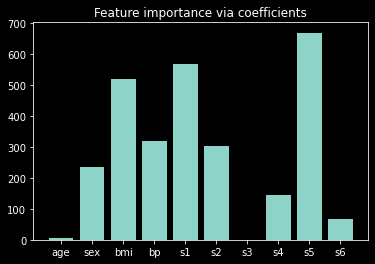

In [13]:
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
plt.style.use("dark_background")

lasso = LassoCV().fit(X, y)
importance = np.abs(lasso.coef_)
feature_names = np.array(load_diabetes().feature_names)
plt.bar(height=importance, x=feature_names)
plt.title("Feature importance via coefficients")
plt.show()

Since we have to pick one, I chose the most important based on lasso regression.

In [14]:
from sklearn.model_selection import train_test_split
import pandas as pd
X = np.array(load_diabetes(as_frame=True)['data']['s5'])

Splitting in training and testing

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0)

Visualizing the problem

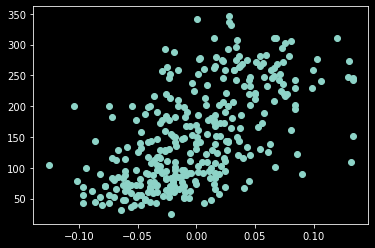

In [16]:
import matplotlib.pyplot as plt
plt.scatter(X_train, y_train)
plt.show()

In [17]:
# Dividing the data into 4 bins
df_cut, bins = pd.cut(X_train, 4, retbins=True, right=True)
df_cut.value_counts()

(-0.126, -0.0612]      36
(-0.0612, 0.00375]    149
(0.00375, 0.0687]     115
(0.0687, 0.134]        31
dtype: int64

In [18]:
df_steps = pd.concat([pd.DataFrame(X_train), pd.DataFrame(df_cut), pd.DataFrame(y_train)], keys=['s5','s5_cuts','target'], axis=1)

# Create dummy variables for the target groups
df_steps_dummies = pd.get_dummies(df_cut)
df_steps_dummies.head()

,"(-0.126, -0.0612]","(-0.0612, 0.00375]","(0.00375, 0.0687]","(0.0687, 0.134]"
0,0,1,0,0
1,0,0,0,1
2,0,0,1,0
3,0,1,0,0
4,0,0,1,0


In [19]:
import statsmodels.api as sm
# Fitting Generalised linear models
piecewise_fit = sm.GLM(df_steps.s5, df_steps_dummies).fit()

# Binning test set into same 4 bins
bin_mapping = np.digitize(X_test, bins)
X_test_mapped = pd.get_dummies(bin_mapping)
# Prediction
piecewise_prediction = piecewise_fit.predict(np.array(X_test_mapped))

In [20]:
# Calculating RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_test, piecewise_prediction))
print(f'The root mean square error is: {rms}')

The root mean square error is: 168.22388710914868


Exploit the same feature selected above, and the same train and test sets to train
and validate a Piecewise polynomial degree 3 with 5 knots (arbitrarily chosen).

In [21]:
from patsy import dmatrix
import statsmodels.api as sm

# Generating cubic spline with 5 knots at 25, 40 and 60 (basis spline)
transformed_x = dmatrix("bs(train, knots=(-0.09,-0.05,0,0.05,0.1), degree=3, include_intercept=False)",
                        {"train": X_train},return_type='dataframe')

# Fitting Generalised linear model on transformed dataset
fit_poly = sm.GLM(y_train, transformed_x).fit()

# Predictions
prediction_poly = fit_poly.predict(dmatrix("bs(test, knots=(-0.09,-0.05,0,0.05,0.1), degree=3, include_intercept=False)",
                                           {"test": X_test},return_type='dataframe'))

# Calculating RMSE values
rms_poly = sqrt(mean_squared_error(y_test, prediction_poly))
print(f'The root mean square error is: {rms_poly}')


The root mean square error is: 63.80624807934038


Use the same data exploited above to train a Natural Spline, degree 3 and 5 knots.
Evaluate the model on the test set, and compare the evaluation with both the
piecewise step function and the piecewise polynomial trained above.

In [22]:
# Generating natural cubic spline (cubic regression)
transformed_x3 = dmatrix("cr(train,df = 3)", {"train": X_train}, return_type='dataframe')
fit_natural_spline = sm.GLM(y_train, transformed_x3).fit()

# Prediction on validation set
prediction_nat = fit_natural_spline.predict(dmatrix("cr(valid, df=3)", {"valid": X_test}, return_type='dataframe'))
# Calculating RMSE value
rms = sqrt(mean_squared_error(y_test, prediction_nat))
print(rms)

63.09139981460205


The evaluation is similar between the natural spline and the polynomial, it's quite worse for the piecewise function
since the way the bins were created does not account for the distribution of the points.

Is there any si+gnificant difference in the performances of the three models? Which
is the reason for this difference? Visualize the data (selected feature f versus target
variable) and the trained models. The performances results are also visible in this
graph?

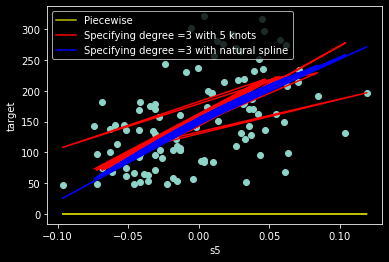

In [23]:
# Plot the splines and error bands
plt.scatter(X_test, y_test)
plt.plot(X_test, piecewise_prediction, color='y', label='Piecewise')
plt.plot(X_test, prediction_poly, color='r', label='Specifying degree =3 with 5 knots')
plt.plot(X_test, prediction_nat, color='b', label='Specifying degree =3 with natural spline')
plt.legend()
plt.xlabel('s5')
plt.ylabel('target')
plt.show()
